In [1]:
# Bayesian linear model of Dissolved Oxygen
# Rio Paraiba do Sul (São Paulo)
import pymc3 as pm
import numpy as np
import os
import pandas as pd

In [2]:
# load data from CSV file
DATA_DIR = "C:\Backup_Fernando\Fernando\Bayesian" 
planilha = os.path.join(DATA_DIR, "Rio_Paraiba_do_Sul.csv")

df = pd.read_csv(planilha, sep=";", decimal=",", header=0)

# Standardize X predictors: autoscale
# chemical physical parameters and river flow

dOD = df['OD']
dDBO = (df['DBO'] - df['DBO'].mean()) / df['DBO'].std()
dSDT = (df['SDT'] - df['SDT'].mean()) / df['SDT'].std()
dCON = (df['Cond'] - df['Cond'].mean()) / df['Cond'].std()
dTA = (df['Temp'] - df['Temp'].mean()) / df['Temp'].std()
dVZ = (df['Vaz'] - df['Vaz'].mean()) / df['Vaz'].std()
dPH = (df['pH'] - df['pH'].mean()) / df['pH'].std()
dFO = (df['Fosf'] - df['Fosf'].mean()) / df['Fosf'].std()
dNO3 = (df['NO3'] - df['NO3'].mean()) / df['NO3'].std()
dNO2 = (df['NO2'] - df['NO2'].mean()) / df['NO2'].std()
dNH3 = (df['NH3'] - df['NH3'].mean()) / df['NH3'].std()
dTU = (df['Turb'] - df['Turb'].mean()) / df['Turb'].std()


In [3]:
#linear model building
with pm.Model() as model:
    a = pm.Normal('a', mu=dOD.mean(), sd=10)
    bA = pm.Normal('bA', mu=0, sd=10, shape=11) # shape = Number of bA's
    #sigma = pm.HalfCauchy('sigma', 5)   
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA[0] * dDBO + bA[1] * dTA + bA[2] * dVZ + bA[3] * dPH + bA[4] * dNH3 + bA[5] * dFO
                          + bA[6] * dCON + bA[7] * dNO3 + bA[8] * dSDT + bA[9] * dNO2 + bA[10] * dTU)
   
    OD = pm.Normal('OD', mu=mu, sd=sigma, observed=dOD)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|███████████████| 4000/4000 [00:24<00:00, 160.67draws/s]


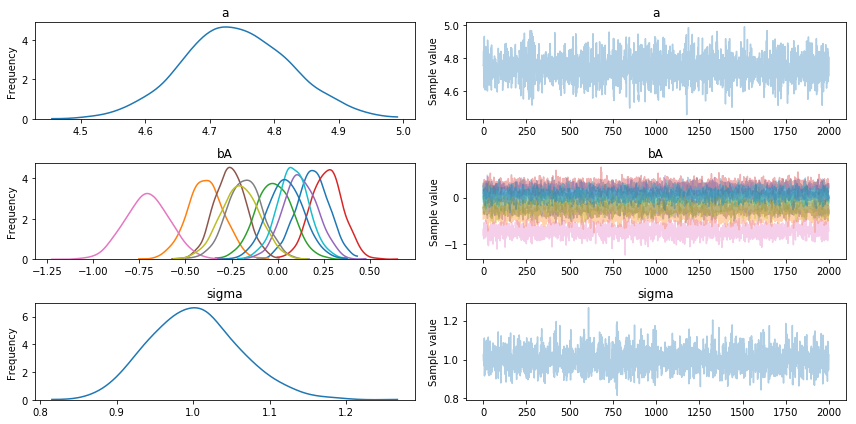

In [4]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace, varnames, combined=True);

In [5]:
pm.summary(trace, varnames, alpha=.11).round(3)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,4.740,0.083,0.001,4.596,4.864,4167.343,1.0
bA__0,0.188,0.088,0.002,0.047,0.328,2492.610,1.0
bA__1,-0.392,0.099,0.002,-0.544,-0.232,2734.923,1.0
bA__2,-0.021,0.099,0.002,-0.173,0.140,2724.749,1.0
bA__3,0.266,0.086,0.002,0.134,0.405,3133.092,1.0
bA__4,0.122,0.093,0.002,-0.020,0.276,2348.130,1.0
bA__5,-0.259,0.085,0.002,-0.391,-0.125,3177.878,1.0
bA__6,-0.709,0.120,0.003,-0.902,-0.527,1886.020,1.0
bA__7,-0.178,0.097,0.002,-0.326,-0.017,3490.770,1.0
bA__8,-0.205,0.106,0.002,-0.360,-0.026,2260.352,1.0


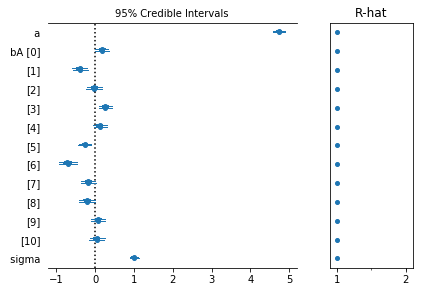

In [6]:
pm.forestplot(trace, varnames=varnames);

In [7]:
OD_pred = pm.sample_posterior_predictive(trace, samples=1000, model=model)['OD']

100%|█████████████████████████████████████| 1000/1000 [00:02<00:00, 374.09it/s]


In [8]:
# Save the DO prediction results as text file
np.savetxt('OD_pred.txt', OD_pred.mean(0), delimiter=' ', newline='\n')